In [42]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Undersatnding Derivative

#### Example 1

In [7]:
def f(x):
  return 3*x**2 - 4*x + 5

In [8]:
f(3.0)

20.0

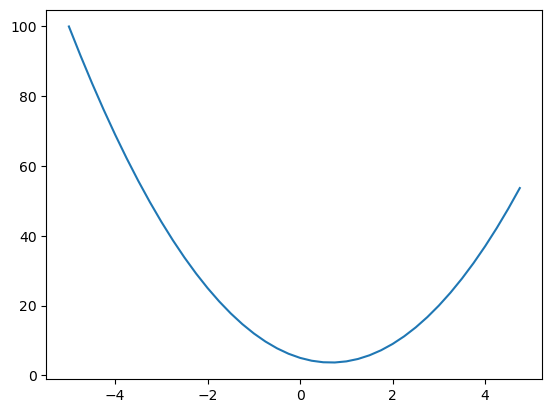

In [9]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [10]:
h = 0.00000001
x = 3.0
(f(x+h)-f(x))/h

14.00000009255109

In [11]:
h = 0.00000001
x = -3.0
(f(x+h)-f(x))/h

-22.00000039920269

#### Example 2

In [12]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
a += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [13]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
b += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [14]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


### Creating a Value object

In [50]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # derivative of the output wrt this value
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
  
  def __repr__(self):
    return f"""Value(data={self.data})"""
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) 
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Only supports int and float powers for now"
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    
    out._backward = _backward

    return out

  def __radd__(self, other): # other + self
    return self + other
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self -other
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward

    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

### Visualization Code

In [16]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name=uid+n._op, label=n._op)
      dot.edge(uid+n._op, uid)
  for n1,n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Example 1

#### Forward pass

In [17]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'

d = e+c
d.label = 'd'

f = Value(-2.0, label='f')

L = d * f
L.label = 'L'

print(L)
print(L._prev)
print(L._op)

Value(data=-8.0)
{Value(data=-2.0), Value(data=4.0)}
*


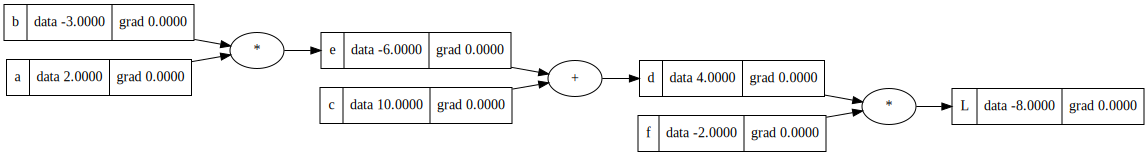

In [18]:
draw_dot(L)

#### Backpropagation

In [19]:
L.grad = 1.0
f.grad = 4.0 # dL/df = d(d*f)/df = d
d.grad = -2.0 # dL/dd = d(d*f)/dd = f
c.grad = -2.0 # dL/dc = dL/dd * dd/dc = -2.0 * d(c+e)/dc = -2.0 * 1
e.grad = -2.0 # dL/de = dL/dd * dd/de = -2.0 * d(c+e)/de = -2.0 * 1
b.grad = -4.0 # dL/da = dL/de * de/da = dL/de * d(a*b)/da = -2.0 * a = -2.0 * 2.0
a.grad = 6.0 # dL/db = dL/de * de/db = dL/de * d(a*b)/db = -2.0 * b = -2.0 * -3.0

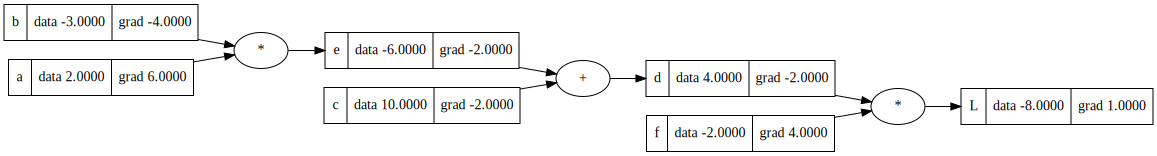

In [20]:
draw_dot(L)

#### Single Optimization Step

In [21]:
# Increase in the direction of gradient
a.data += 0.01 * a.grad
b.data -= 0.01 * b.grad
c.data -= 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.687904


### Example 2

#### Forward Pass & Manual backpropagation

In [22]:
# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias: b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2#w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

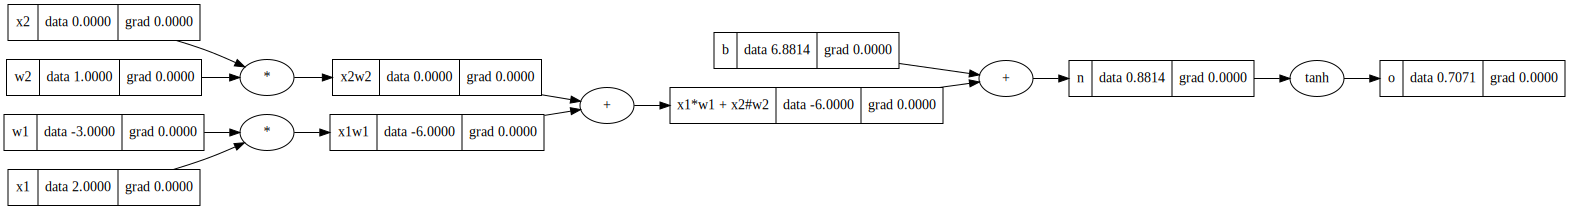

In [23]:
draw_dot(o)

In [24]:
o.grad = 1.0
n.grad = 1 - o.data**2 # d0/dn = 1 - tanh(n)**2 = 1 - o**2

# + is just distributor of the gradient
x1w1x2w2.grad = n.grad
b.grad = n.grad
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

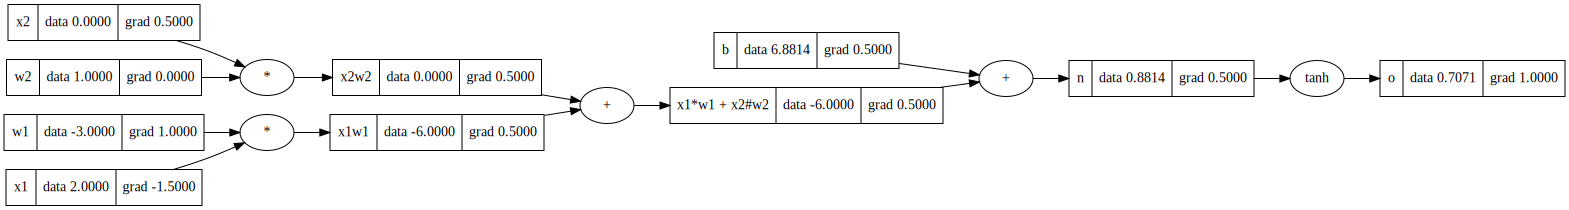

In [25]:
draw_dot(o)

#### Forward pass and backpropagation

In [26]:
# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias: b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2#w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

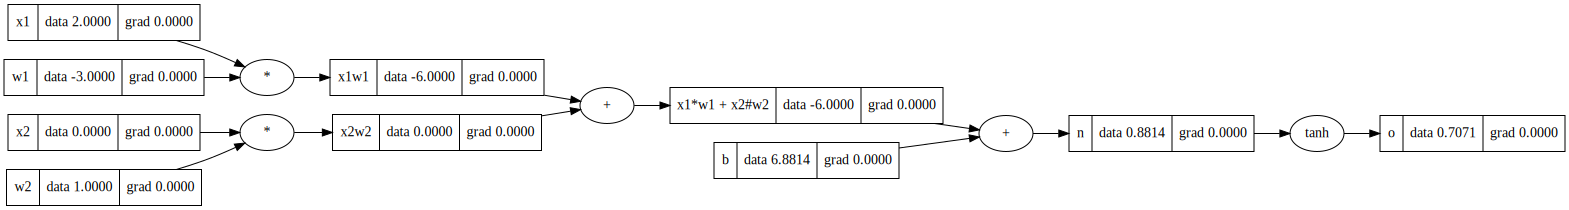

In [27]:
draw_dot(o)

In [28]:
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

o.backward()

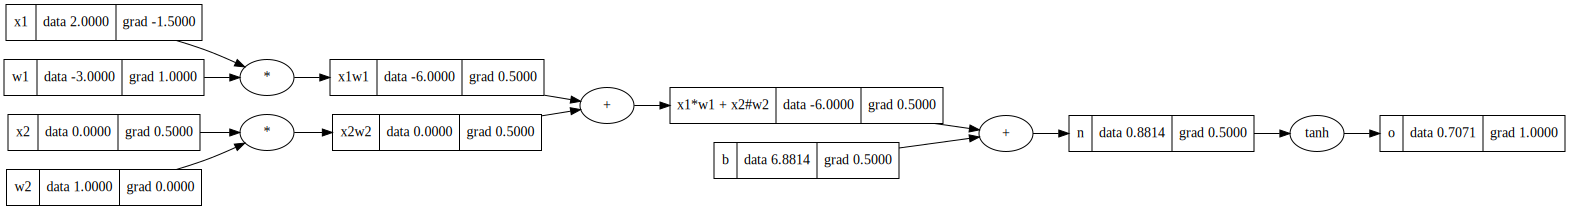

In [29]:
draw_dot(o)

#### Bug
Use of same variable more than once

In [30]:
# Before

# a = Value(3.0, label='a')
# b = a + a
# b.backward()
# draw_dot(b)

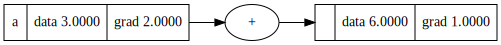

In [31]:
a = Value(3.0, label='a')
b = a + a
b.backward()
draw_dot(b)

### Adding more functions to Value class

#### Power

In [32]:
a = Value(2.0, label='a')
b = a.exp(); b.label = 'b'

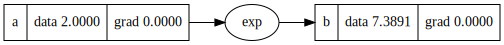

In [33]:
draw_dot(b)

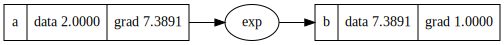

In [34]:
b.backward()
draw_dot(b)

#### Division

In [35]:
a = Value(2.0)
b = Value(4.0)

In [36]:
print(a/b)
print(a-b)

Value(data=0.5)
Value(data=-2.0)


### Example 2 (by breaking down tanh)

In [38]:
# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias: b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2#w2'

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'

In [39]:
o.backward()

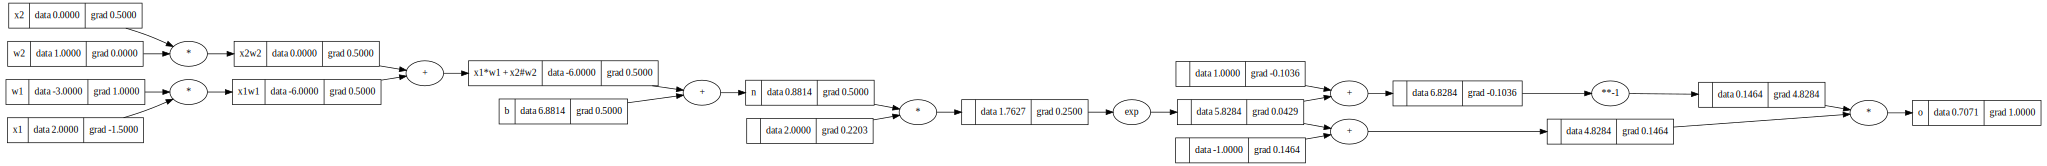

In [40]:
draw_dot(o)

### Example 2 in PyTorch

In [41]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Multi-Layer Perceptron in micrograd

In [55]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

In [59]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9845674252074528)